In [9]:
import numpy as np
import scipy as sp
import suite2p as s2p
import TwoPUtils as tpu
import STX3KO_analyses as stx

import os
from matplotlib import pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [4]:
write_folder = os.path.join('/home/mplitt','2P_scratch')


mouse = 'CA3-1'

file_list = ({'date': '14_10_2021', 'scene':'YMaze_LNovel','session':1,'scan':3},)

In [5]:
def check_and_make_h5s(file_list, runh5=True):
    h5list, framerates = [], []
    for f in file_list:
        print(f)
        scan_str = "%s_%03d_%03d" % (f['scene'],f['session'],f['scan'])
        source_folder  = os.path.join('/home','mplitt','2P_scratch')
        source_stem = os.path.join(source_folder,mouse,f['date'],f['scene'],scan_str)
        info = TwoPUtils.scanner_tools.sbx_utils.loadmat(source_stem+'.mat')
        
        file_stem = os.path.join(write_folder,mouse,f['date'],f['scene'],scan_str)
        h5path = os.path.join(file_stem,scan_str+".h5")
        if not os.path.exists(h5path) and runh5:
            _ = TwoPUtils.scanner_tools.sbx_utils.sbx2h5(source_stem,output_name=h5path,force_2chan=False)

        h5list.append(file_stem)
        framerates.append(info['frame_rate'])
    print(h5list)
    return h5list, framerates

In [5]:
for f in file_list:
    
    _h5list,_frs = check_and_make_h5s([f,],runh5=True)
    ops_dir = os.path.join(_h5list[0],'suite2p','plane0','ops.npy')
    s2p_dir = os.path.join(_h5list[0],'suite2p','plane0')
    if os.path.exists(ops_dir):
        ops = np.load(os.path.join(s2p_dir,"ops.npy"),allow_pickle=True).all()
        ops['reg_file'] = os.path.join(s2p_dir,"data.bin")
#         ops['reg_file_chan2'] = os.path.join(s2p_dir,"data_chan2.bin")
        np.save(ops_dir,ops)

    # if ops file exists
        # update paths to be local paths
    ops = TwoPUtils.s2p.set_ops(d={'data_path': _h5list,
                                   'save_path0': _h5list[0],
                                    'fast_disk':[],
                                    'move_bin':True,
                                    'two_step_registration':True,
                                    'maxregshiftNR':10,
                                    'tau':.7,
                                    'functional_chan':1,
                                    'fs':_frs[0],
                                    'roidetect':True,
                                    'input_format':"h5",
                                    'h5py_key':'data',
                                    'nchannels':1,
                                    'threshold_scaling':1,
                                    'chan2_thresh':.01})
    ops=s2p.run_s2p(ops=ops)
    !rm {_h5list[0]}/*.h5 

{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}
['/home/mplitt/2P_scratch/CA3-1/14_10_2021/YMaze_LNovel/YMaze_LNovel_001_003']
{}
FOUND BINARIES AND OPS IN ['/home/mplitt/2P_scratch/CA3-1/14_10_2021/YMaze_LNovel/YMaze_LNovel_001_003/suite2p/plane0/ops.npy']
>>>>>>>>>>>>>>>>>>>>> PLANE 0 <<<<<<<<<<<<<<<<<<<<<<
NOTE: not registered / registration forced with ops['do_registration']>1
      (no previous offsets to delete)
----------- REGISTRATION
registering 25174 frames
NOTE: estimated bidiphase offset from data: 1 pixels
Reference frame, 18.19 sec.
Registered 2000/25174 in 75.94s
Registered 4000/25174 in 151.53s
Registered 6000/25174 in 225.42s
Registered 8000/25174 in 301.69s
Registered 10000/25174 in 376.15s
Registered 12000/25174 in 452.57s
Registered 14000/25174 in 525.24s
Registered 16000/25174 in 602.48s
Registered 18000/25174 in 678.58s
Registered 20000/25174 in 757.78s
Registered 22000/25174 in 836.27s
Registered 24000/25174 in 915.27s
----------- Total 9

In [1]:
def update_sess_dict(mouse, f, KO = True):
    scan_str = "%s_%03d_%03d" % (f['scene'],f['session'],f['scan'])

            
    source_folder = "/home/mplitt/2P_scratch"
    source_stem = os.path.join(source_folder, mouse, f['date'], f['scene'], scan_str)

    f['mouse']=mouse
    f.update({'scan_file': source_stem + '.sbx',
              'scanheader_file': source_stem + '.mat',
              'vr_filename': os.path.join("/home/mplitt/VR_scratch",f['mouse'],f['date'],"%s_%d.sqlite" %(f['scene'],f['session'])),
              'scan_number': f['scan'],
              'prompt_for_keys': False,
              'VR_only': False,
              'scanner': "NLW",
             })
    return f

In [2]:
def run_and_save(fdict,comb_frames=0):
#     with open(os.path.join('/home/mplitt/YMazeSessPkls',mouse,deets['date'], "%s_%d.pkl" % (deets['scene'],deets['session'])),'rb') as file:
#         sess = dill.load(file)
#     sess.novel_arm = fdict['novel']    
            
    sess = stx.session.YMazeSession(**fdict)
    sess.load_scan_info()
    sess.align_VR_to_2P()
    sess.load_suite2p_data(which_ts=('F', 'Fneu','spks'), frames = slice(comb_frames,comb_frames+sess.scan_info['max_idx']))
    sess.get_trial_info()
    sess.neuropil_corrected_dff()
    
    
    sess.place_cells_calc(nperms=1000)
    
    sess.add_pos_binned_trial_matrix('F_dff')
    sess.add_timeseries(F_dff_norm = sess.timeseries['F_dff']/np.nanpercentile(sess.timeseries['F_dff'],99,axis=1,keepdims=True))
    sess.rm_pos_binned_trial_matrix('F_dff_norm')
    sess.add_pos_binned_trial_matrix('F_dff_norm')
    
    sess.add_pos_binned_trial_matrix('spks') #,speed=sess.vr_data['dz']._values, speed_thr = .05)  
    sess.add_timeseries(spks_norm = sess.timeseries['spks']/np.nanpercentile(sess.timeseries['spks'],99,axis=1,keepdims=True))
    sess.add_pos_binned_trial_matrix('spks_norm') 

    sess.add_timeseries(licks=sess.vr_data['lick']._values)
    sess.add_pos_binned_trial_matrix('licks')
    sess.add_timeseries(speed=sess.vr_data['dz']._values)
    sess.add_pos_binned_trial_matrix('speed')
    
    TwoPUtils.sess.save_session(sess,'/home/mplitt/YMazeSessPkls')
    return comb_frames+sess.scan_info['max_idx']

In [6]:
f = {'date': '14_10_2021', 'scene':'YMaze_LNovel','session':1,'scan':3, 'novel_arm':-1, 'ravel_ind': 0}
f_ = update_sess_dict(mouse,f)

In [7]:
f_

{'date': '14_10_2021',
 'scene': 'YMaze_LNovel',
 'session': 1,
 'scan': 3,
 'novel_arm': -1,
 'ravel_ind': 0,
 'mouse': 'CA3-1',
 'scan_file': '/home/mplitt/2P_scratch/CA3-1/14_10_2021/YMaze_LNovel/YMaze_LNovel_001_003.sbx',
 'scanheader_file': '/home/mplitt/2P_scratch/CA3-1/14_10_2021/YMaze_LNovel/YMaze_LNovel_001_003.mat',
 'vr_filename': '/home/mplitt/VR_scratch/CA3-1/14_10_2021/YMaze_LNovel_1.sqlite',
 'scan_number': 3,
 'prompt_for_keys': False,
 'VR_only': False,
 'scanner': 'NLW'}

In [10]:
_ = run_and_save(f_)

Fixing teleports
(117971,) (25174,)
1623.3403022670025 1623.246347607053
/home/mplitt/2P_scratch/CA3-1/14_10_2021/YMaze_LNovel/YMaze_LNovel_001_003/suite2p


/home/mplitt/repos/TwoPUtils/TwoPUtils/preprocessing.py:233: UserWarning: Number of teleports and trial starts don't match
  warnings.warn("Number of teleports and trial starts don't match")
/home/mplitt/repos/TwoPUtils/TwoPUtils/preprocessing.py:239: UserWarning: One more trial start than teleport, assuming the final teleport got chopped
  warnings.warn(('One more trial start than teleport, assuming the final teleport got chopped'))


174 3375
4319 7219
8154 11104
12039 15069
16003 19083
20017 25173
perm 0
perm 100
perm 200
perm 300
perm 400
perm 500
perm 600
perm 700
perm 800
perm 900
perm 0
perm 100
perm 200
perm 300
perm 400
perm 500
perm 600
perm 700
perm 800
perm 900


In [12]:
sess = stx.session.YMazeSession.from_file(os.path.join("/home/mplitt/YMazeSessPkls", mouse, f['date'], "%s_%d.pkl" % (f['scene'], f['session'])))

In [15]:
sess.timeseries.keys()

dict_keys(['F', 'Fneu', 'spks', 'F_dff', 'F_dff_norm', 'spks_norm', 'licks', 'speed'])

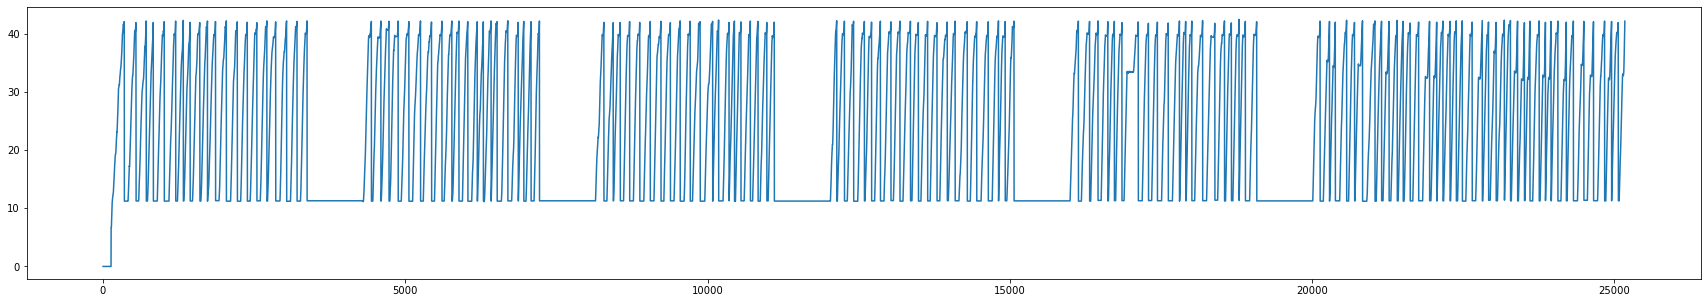

In [20]:
fig, ax = plt.subplots(figsize = [30,5])
ax.plot(sess.vr_data['t'])


In [24]:
sess.place_cell_info['right']['masks'].sum()

76

<ipython-input-35-d34e941ef79c>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax = plt.subplots()


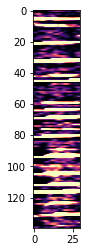

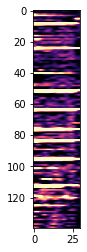

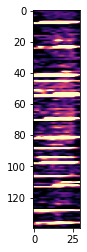

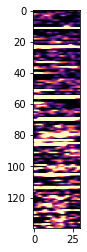

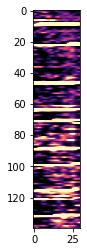

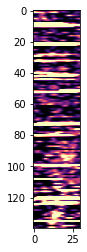

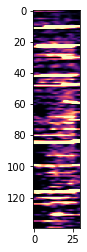

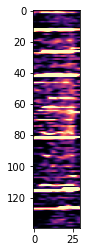

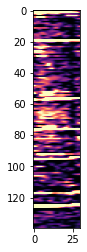

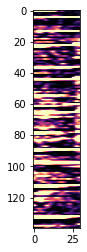

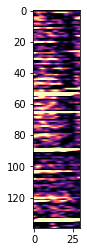

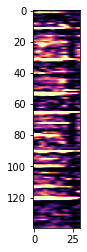

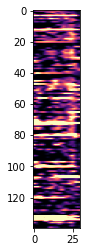

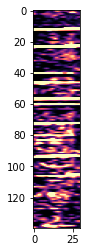

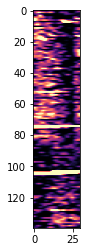

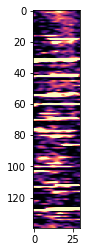

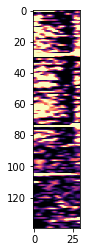

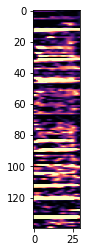

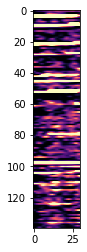

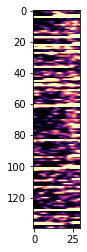

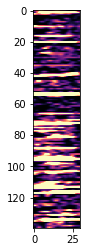

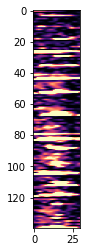

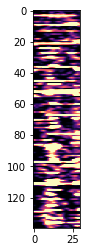

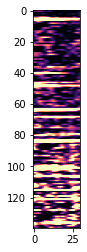

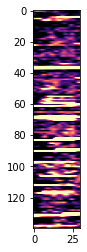

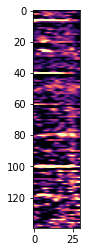

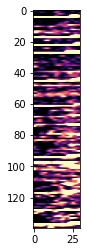

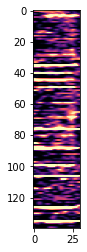

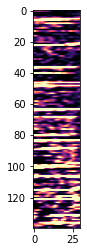

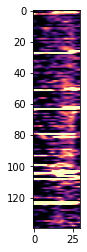

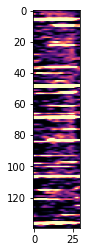

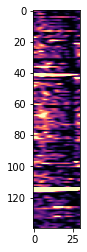

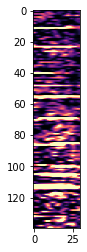

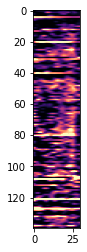

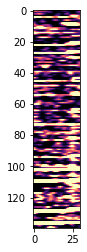

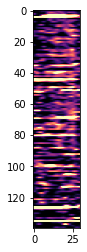

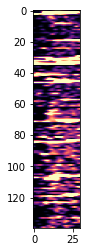

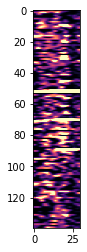

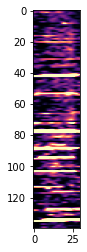

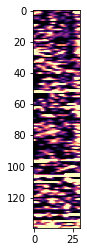

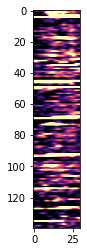

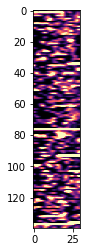

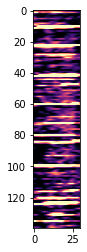

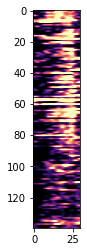

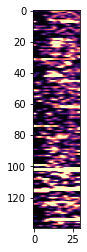

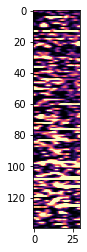

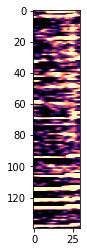

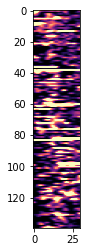

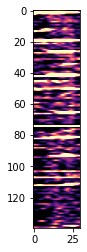

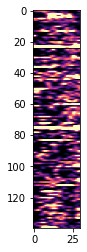

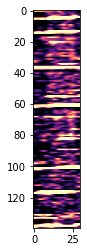

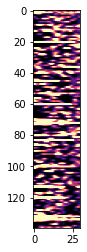

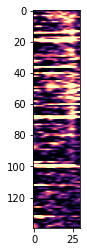

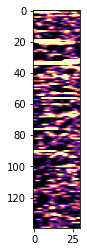

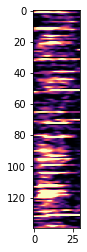

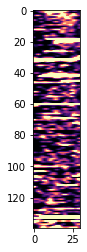

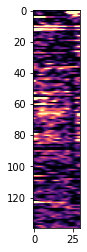

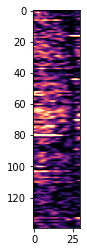

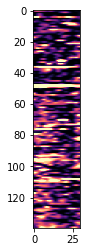

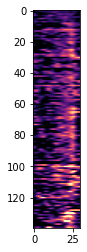

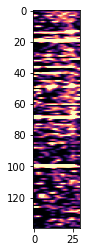

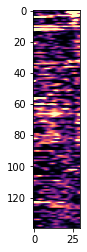

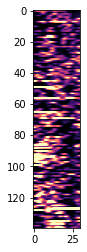

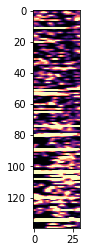

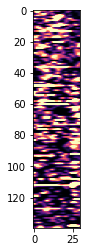

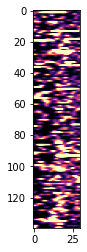

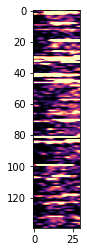

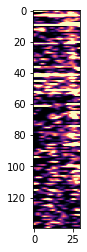

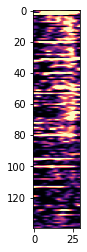

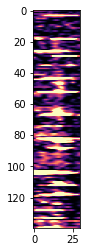

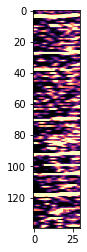

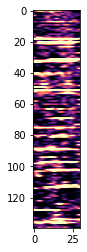

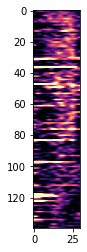

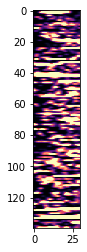

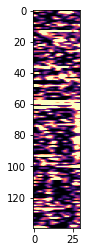

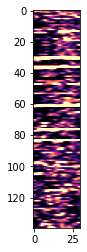

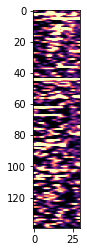

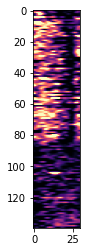

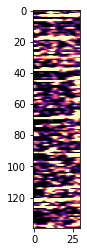

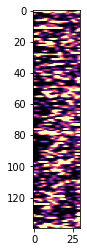

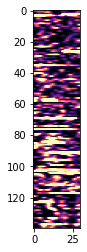

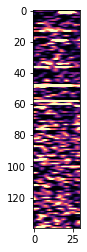

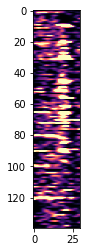

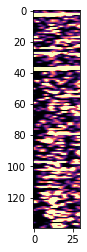

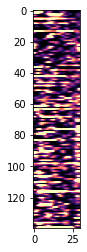

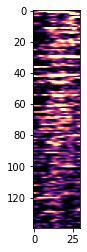

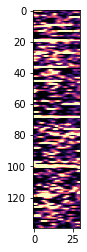

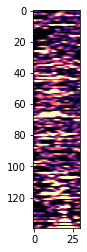

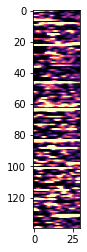

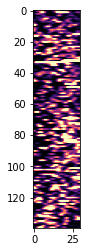

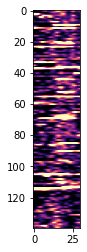

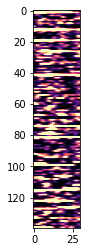

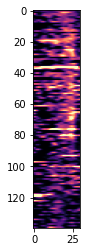

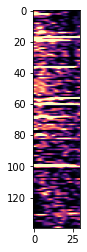

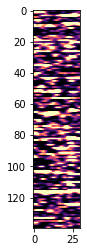

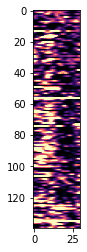

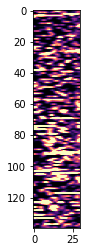

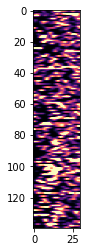

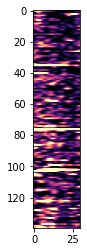

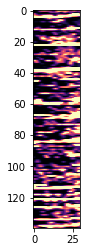

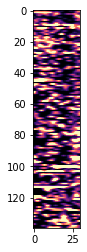

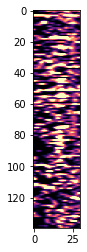

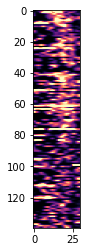

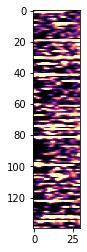

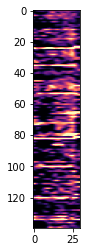

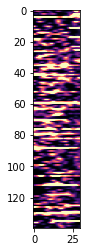

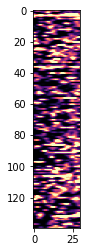

In [35]:
tmat = sess.trial_matrices['spks']
tmat[np.isnan(tmat)]=1E-3
for cell in range(sess.trial_matrices['spks'].shape[-1]):
    fig,ax = plt.subplots()
    tmp = sp.ndimage.gaussian_filter1d(tmat[:,:,cell],1,axis=-1)
    ax.imshow(tmp/np.median(tmp.ravel()), cmap = 'magma', aspect= 1,vmax=5)